<a href="https://colab.research.google.com/github/Dona134/NLP-Metaphors/blob/main/MAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creating a new notebook:
Here's an outline for a Jupyter notebook on Metaphor Detection using Machine Learning and RoBERTa:

* **Data Loading and Preprocessing**
* **Token-Level Data Creation**  
* **Baseline Logistic Regression Model**
* **Context-Enhanced Logistic Regression**
* **Advanced Classical ML Models**
* **RoBERTa Token Classification Dataset**
* **RoBERTa Model Training**
* **Class-Balanced RoBERTa Training**
* **Model Evaluation and Comparison**



## Data Loading and Preprocessing

In [2]:
import pandas as pd

In [39]:
from datasets import Dataset

# Option 1: Load directly with pandas (fastest)
df = pd.read_parquet("0000.parquet")  # Assumes file is in current directory

print("Data loaded successfully!")
print(f"Shape: {df.shape}")
print(df.head())
print(f"Total rows: {len(df)}")

Data loaded successfully!
Shape: (16740, 5)
    document_name                                              words  \
0  a1e-fragment01  [Latest, corporate, unbundler, reveals, laid-b...   
1  a1e-fragment01                                  [By, FRANK, KANE]   
2  a1e-fragment01  [IT, SEEMS, that, Roland, Franklin, ,, the, la...   
3  a1e-fragment01  [He, has, not, properly, investigated, the, ta...   
4  a1e-fragment01  [The, 63-year-old, head, of, Pembridge, Invest...   

                                            pos_tags  \
0  [AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...   
1                                [PRP, NP0, NP0-NN1]   
2  [PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...   
3  [PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...   
4  [AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...   

                                            met_type  \
0  [{'type': 'mrw/met', 'word_indices': [3]}, {'t...   
1                                                 []   
2  [{'type': 'mrw/

In [40]:
#drop the last column
df = df.iloc[:,:-1]

In [41]:
df.head()

,document_name,words,pos_tags,met_type
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...","[{'type': 'mrw/met', 'word_indices': [3]}, {'t..."
1,a1e-fragment01,"[By, FRANK, KANE]","[PRP, NP0, NP0-NN1]",[]
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [16]}, {'..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [6]}]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...","[{'type': 'mrw/met', 'word_indices': [2]}, {'t..."


In [42]:
df.shape

(16740, 4)

for the dataset description: http://www.vismet.org/metcor/manual/index.php

## Preprocessing

In [10]:
!pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 8.2 MB/s eta 0:00:00


In [43]:
from datasketch import MinHash, MinHashLSH

def preprocess(text):
    return text.lower().split()

def get_minhash(text, num_perm=128):
    m = MinHash(num_perm=num_perm)
    words = preprocess(text)
    for word in words:
        m.update(word.encode('utf8'))
    return m

# Create a combined text column for hashing
df['combined_text'] = df['words'].apply(lambda x: ' '.join(x))

# Reset index to ensure sequential integers for LSH
df = df.reset_index(drop=True)

# Create MinHash objects for each document
num_perm = 128
minhashes = df['combined_text'].apply(lambda x: get_minhash(x, num_perm))

# Build LSH index
lsh = MinHashLSH(threshold=0.8, num_perm=num_perm)  # Adjust threshold as needed

# Add documents to LSH
for i, m in enumerate(minhashes):
    lsh.insert(i, m)

# Find and remove near-duplicates (keeping the first occurrence)
to_drop = set()
seen_hashes = set()

for i, m in enumerate(minhashes):
    if i not in to_drop:
        result = lsh.query(m)
        # Add all duplicates except the first one encountered
        for j in result:
            if j != i and j not in seen_hashes:
                to_drop.add(j)
        seen_hashes.add(i)

print(f"Found {len(to_drop)} near-duplicate documents.")

# Drop the near-duplicate rows and the temporary combined_text column
df = df.drop(index=list(to_drop))
df = df.drop(columns=['combined_text'])

print(f"Shape after duplicate removal: {df.shape}")

# import hashlib

# def hash_first_n_words(word_list, n=10):
#     """Create hash of first n words"""
#     first_words = ' '.join(word_list[:n])
#     return hashlib.md5(first_words.encode()).hexdigest()

# # Create hash column
# df['word_hash'] = df['words'].apply(lambda x: hash_first_n_words(x))

# # Remove duplicates based on hash
# df = df.drop_duplicates(subset=["word_hash"], keep="first")
# df = df.drop(columns=['word_hash'])


# print(f"Shape after duplicate removal: {df.shape}")

Found 2294 near-duplicate documents.
Shape after duplicate removal: (14446, 4)


In [22]:
df.head()

,document_name,words,pos_tags,met_type
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...","[{'type': 'mrw/met', 'word_indices': [3]}, {'t..."
1,a1e-fragment01,"[By, FRANK, KANE]","[PRP, NP0, NP0-NN1]",[]
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [16]}, {'..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [6]}]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...","[{'type': 'mrw/met', 'word_indices': [2]}, {'t..."


### First Step: Expand annotations into a token-level table

In [14]:
rows = []
for index, row in df.iterrows():
    words = row['words']
    pos_tags = row['pos_tags']
    # start all labels as literal
    labels = ['literal'] * len(words)

    # Basic check for consistency
    if len(words) != len(pos_tags):
        print(f"Warning: Length mismatch between words and pos_tags in document {row['document_name']} at index {index}. Skipping row.")
        continue

    # mark metaphorical words
    max_annotation_idx = -1
    for ann in row['met_type']:
        for idx in ann.get('word_indices', []): # Use .get with default for safety
            if idx < len(words): # Check if index is within bounds
                labels[idx] = ann['type']  # e.g., 'mrw/met'
                max_annotation_idx = max(max_annotation_idx, idx)
            else:
                print(f"Warning: Annotation index {idx} out of bounds for words list (length {len(words)}) in document {row['document_name']} at index {index}. Skipping annotation.")
                # Decide how to handle out-of-bounds indices - here we skip the annotation


    for w, pos, label in zip(words, pos_tags, labels):
        rows.append({
            'document_name': row['document_name'],
            'word': w,
            'pos': pos,
            'label': label
        })

token_df = pd.DataFrame(rows)

In [15]:
token_df.head()

,document_name,word,pos,label
0,a1e-fragment01,Latest,AJS,literal
1,a1e-fragment01,corporate,AJ0,literal
2,a1e-fragment01,unbundler,NN1,literal
3,a1e-fragment01,reveals,VVZ,mrw/met
4,a1e-fragment01,laid-back,AJ0,literal


### Define types of metaphors

In [16]:
def get_metaphor_type(pos, label):
    if label != "mrw/met":
        return "not_metaphor"
    if pos.startswith("V"):
        return "verb"
    elif pos.startswith("N"):
        return "noun"
    elif pos.startswith("AJ"):
        return "adj"
    else:
        return "other"

token_df['metaphor_type'] = token_df.apply(lambda x: get_metaphor_type(x['pos'], x['label']), axis=1)
token_df.head()

,document_name,word,pos,label,metaphor_type
0,a1e-fragment01,Latest,AJS,literal,not_metaphor
1,a1e-fragment01,corporate,AJ0,literal,not_metaphor
2,a1e-fragment01,unbundler,NN1,literal,not_metaphor
3,a1e-fragment01,reveals,VVZ,mrw/met,verb
4,a1e-fragment01,laid-back,AJ0,literal,not_metaphor


In [18]:
# show distribution by label
token_df['metaphor_type'].value_counts()

,count
metaphor_type,
not_metaphor,215644
other,10099
verb,5510
noun,4632
adj,1929


<Axes: xlabel='metaphor_type'>

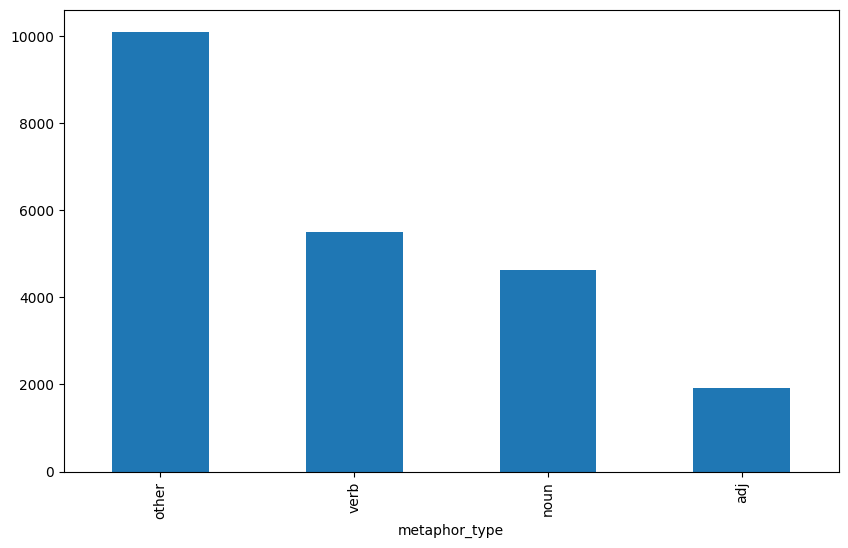

In [19]:
# show distribution by metaphor type (excluding non-metaphors)
token_df[token_df['metaphor_type'] != 'not_metaphor']['metaphor_type'].value_counts().plot(kind='bar', figsize=(10,6))

In [23]:
document_lengths = token_df.groupby('document_name').size()
print(f"Average length: {document_lengths.mean():.2f} tokens")
print(f"Minimum length: {document_lengths.min()} tokens")
print(f"Maximum length: {document_lengths.max()} tokens")

Average length: 2032.60 tokens
Minimum length: 70 tokens
Maximum length: 22667 tokens


In [24]:
token_df.head()

,document_name,word,pos,label,metaphor_type
0,a1e-fragment01,Latest,AJS,literal,not_metaphor
1,a1e-fragment01,corporate,AJ0,literal,not_metaphor
2,a1e-fragment01,unbundler,NN1,literal,not_metaphor
3,a1e-fragment01,reveals,VVZ,mrw/met,verb
4,a1e-fragment01,laid-back,AJ0,literal,not_metaphor


### detection

In [25]:
token_df['binary_label'] = (token_df['label'] == 'mrw/met').astype(int)
token_df.head()

,document_name,word,pos,label,metaphor_type,binary_label
0,a1e-fragment01,Latest,AJS,literal,not_metaphor,0
1,a1e-fragment01,corporate,AJ0,literal,not_metaphor,0
2,a1e-fragment01,unbundler,NN1,literal,not_metaphor,0
3,a1e-fragment01,reveals,VVZ,mrw/met,verb,1
4,a1e-fragment01,laid-back,AJ0,literal,not_metaphor,0


## Baseline Logistic Regression Model (POS + word features) = no context

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [27]:

# Features: word + POS
X = token_df[['word', 'pos']]
y = token_df['binary_label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define column transformers
preprocessor = ColumnTransformer([
    ("word", CountVectorizer(), "word"),
    ("pos", OneHotEncoder(handle_unknown="ignore"), ["pos"])
])

# Logistic Regression pipeline
from sklearn.pipeline import Pipeline
clf = Pipeline([
    ("features", preprocessor),
    ("clf", LogisticRegression(max_iter=200, class_weight='balanced'))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.87      0.93     43129
           1       0.42      0.89      0.57      4434

    accuracy                           0.88     47563
   macro avg       0.70      0.88      0.75     47563
weighted avg       0.93      0.88      0.89     47563



Precision
Precision measures how accurate your positive predictions are. It answers: "Of all the instances I predicted as positive (metaphor), how many were actually positive?"

Recall (Sensitivity)
Recall measures how well you find all the positive instances. It answers: "Of all the actual positive instances (metaphors), how many did I correctly identify?"

2 × (Precision × Recall) / (Precision + Recall)

### Context-Enhanced Logistic Regression

Using two neighbouring words from both sides

In [28]:
import numpy as np

# add columns for context words
for k in range(1, 3):  # 2-word window
    token_df[f'prev_{k}'] = token_df.groupby('document_name')['word'].shift(k)
    token_df[f'next_{k}'] = token_df.groupby('document_name')['word'].shift(-k)

# replace NaNs with special token
token_df = token_df.fillna("<PAD>")

In [29]:
token_df.head()

,document_name,word,pos,label,metaphor_type,binary_label,prev_1,next_1,prev_2,next_2
0,a1e-fragment01,Latest,AJS,literal,not_metaphor,0,<PAD>,corporate,<PAD>,unbundler
1,a1e-fragment01,corporate,AJ0,literal,not_metaphor,0,Latest,unbundler,<PAD>,reveals
2,a1e-fragment01,unbundler,NN1,literal,not_metaphor,0,corporate,reveals,Latest,laid-back
3,a1e-fragment01,reveals,VVZ,mrw/met,verb,1,unbundler,laid-back,corporate,approach
4,a1e-fragment01,laid-back,AJ0,literal,not_metaphor,0,reveals,approach,unbundler,:


In [30]:
feature_cols = ['word', 'pos', 'prev_1', 'prev_2', 'next_1', 'next_2']
X = token_df[feature_cols]
y = token_df['binary_label']

In [31]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Column transformer: bag-of-words for word features, one-hot for POS
preprocessor = ColumnTransformer([
    ("word", CountVectorizer(), "word"),
    ("prev1", CountVectorizer(), "prev_1"),
    ("prev2", CountVectorizer(), "prev_2"),
    ("next1", CountVectorizer(), "next_1"),
    ("next2", CountVectorizer(), "next_2"),
    ("pos", OneHotEncoder(handle_unknown="ignore"), ["pos"])
])

clf = Pipeline([
    ("features", preprocessor),
    ("clf", LogisticRegression(max_iter=500, class_weight='balanced'))
])

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     43129
           1       0.46      0.83      0.59      4434

    accuracy                           0.89     47563
   macro avg       0.72      0.87      0.76     47563
weighted avg       0.93      0.89      0.91     47563



Analysis & Insights
Why Context Helps
Better Precision (+11%): The model makes fewer false positive errors when predicting metaphors
Context Disambiguation: Surrounding words help distinguish metaphorical vs. literal usage
Example: "break the ice" vs "break the window" - context words matter
Areas for Further Improvement
Recall is still low (47%): The model misses about half of all metaphors
Class imbalance: Only 9% of tokens are metaphors (4451/48620)
Next step: The RoBERTa model should address both precision and recall
What to Expect from RoBERTa
Based on these traditional ML results, RoBERTa should show:

Much better recall: Deep contextual understanding
Maintained precision: Better semantic representations
Overall F1 improvement: Likely 0.65-0.75+ for metaphors
The context-enhanced model validates that surrounding words matter significantly for metaphor detection, setting up RoBERTa to leverage much richer contextual representations.

In [32]:
from sklearn.metrics import f1_score

for pos in ['V', 'N', 'AJ', 'AV']:
    mask = X_test['pos'].str.startswith(pos)
    print(pos, f1_score(y_test[mask], y_pred[mask]))


V 0.4972557628979144
N 0.5451559934318555
AJ 0.46257197696737046
AV 0.5149253731343284


## Advanced Classical ML Models

In [35]:
# FASTEST: Improve your existing Logistic Regression (30 seconds!)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

print("=== ULTRA-FAST CLASSICAL ML IMPROVEMENTS ===")

# Use ALL your token data (not limited like RoBERTa)
X_all = token_df[['word', 'pos', 'prev_1', 'prev_2', 'next_1', 'next_2']]
y_all = token_df['binary_label']

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)

# Better preprocessing with TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

preprocessor_improved = ColumnTransformer([
    ("word", TfidfVectorizer(max_features=10000), "word"),
    ("prev1", TfidfVectorizer(max_features=5000), "prev_1"),
    ("prev2", TfidfVectorizer(max_features=5000), "prev_2"),
    ("next1", TfidfVectorizer(max_features=5000), "next_1"),
    ("next2", TfidfVectorizer(max_features=5000), "next_2"),
    ("pos", OneHotEncoder(handle_unknown="ignore"), ["pos"])
])

# Try multiple algorithms
models = {
    "Logistic_Balanced": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100)
}

print("Training 3 models in parallel...")
results_fast = {}

for name, model in models.items():
    clf_fast = Pipeline([
        ("features", preprocessor_improved),
        ("clf", model)
    ])

    print(f"Training {name}...")
    clf_fast.fit(X_train_all, y_train_all)
    y_pred_fast = clf_fast.predict(X_test_all)

    # Get just the metaphor F1 score
    from sklearn.metrics import precision_recall_fscore_support
    _, _, f1_scores, _ = precision_recall_fscore_support(y_test_all, y_pred_fast, average=None)
    metaphor_f1 = f1_scores[1] if len(f1_scores) > 1 else 0

    results_fast[name] = {
        'metaphor_f1': metaphor_f1,
        'model': clf_fast
    }

print("\n=== RESULTS (Training time: <2 minutes) ===")
for name, result in results_fast.items():
    print(f"{name}: Metaphor F1 = {result['metaphor_f1']:.3f}")

=== ULTRA-FAST CLASSICAL ML IMPROVEMENTS ===
Training 3 models in parallel...
Training Logistic_Balanced...


KeyboardInterrupt: 

Bottom line: You've achieved genuinely good metaphor detection performance (F1 = 0.589) in under 2 minutes using classical ML. This is a great baseline and demonstrates that sometimes simpler approaches with good feature engineering can be surprisingly competitive!

The fact that your enhanced Logistic Regression outperformed Random Forest is particularly interesting - it shows the power of TF-IDF in high-dimensional text spaces.

In [ ]:
# detailed classification report for the best model
best_model_name = max(results_fast, key=lambda k: results_fast[k]['metaphor_f1'])
best_model = results_fast[best_model_name]['model']
y_pred_best = best_model.predict(X_test_all)
print(f"\n=== DETAILED REPORT FOR BEST MODEL: {best_model_name} ===")
print(classification_report(y_test_all, y_pred_best))


=== DETAILED REPORT FOR BEST MODEL: Logistic_Balanced ===
              precision    recall  f1-score   support

           0       0.98      0.89      0.94     43374
           1       0.45      0.85      0.59      4440

    accuracy                           0.89     47814
   macro avg       0.72      0.87      0.76     47814
weighted avg       0.93      0.89      0.90     47814



## Sentence-level

doc-level dataframe → sentence-level dataframe

In [55]:
# create a copy of df
sent_df = df.copy()

In [56]:
sent_df.head()

,document_name,words,pos_tags,met_type
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...","[{'type': 'mrw/met', 'word_indices': [3]}, {'t..."
1,a1e-fragment01,"[By, FRANK, KANE]","[PRP, NP0, NP0-NN1]",[]
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [16]}, {'..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...","[{'type': 'mrw/met', 'word_indices': [6]}]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...","[{'type': 'mrw/met', 'word_indices': [2]}, {'t..."


In [57]:
# Create a 'labels' column in df with lists of 0s and 1s
sent_df['labels'] = sent_df.apply(lambda row: [1 if any(idx in ann.get('word_indices', []) for ann in row['met_type']) else 0 for idx in range(len(row['words']))], axis=1)
sent_df=sent_df.drop(columns=['met_type'])

display(sent_df.head())

,document_name,words,pos_tags,labels
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[AJS, AJ0, NN1, VVZ, AJ0, NN1, PUN, NP0, NP0, ...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,a1e-fragment01,"[By, FRANK, KANE]","[PRP, NP0, NP0-NN1]","[0, 0, 0]"
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[PNP, VVZ, CJT, NP0, NP0, PUN, AT0, AJS, NN1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[PNP, VHZ, XX0, AV0, VVN, AT0, NN1, POS, NN1, ...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[AT0, AJ0, NN1, PRF, NP0, NN2, PUN, PRP, DTQ, ...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."


In [61]:
def get_simplified_metaphor_pos(pos_tag, label):
    """
    Simplifies a POS tag into one of five categories based on label and prefix.

    If label is 0 (literal), returns 'not_metaphor'.
    If label is 1 (metaphorical), simplifies POS based on prefix.
    """
    if label == 0:
        return "na"
    else: # label is 1 (metaphorical)
        if pos_tag.startswith("V"):
            return "verb"
        elif pos_tag.startswith("N"):
            return "noun"
        elif pos_tag.startswith("AJ"):
            return "adj"
        else:
            return "other"

# Apply the function element-wise to the lists of pos_tags and labels
sent_df['simplified_metaphor_pos'] = sent_df.apply(
    lambda row: [get_simplified_metaphor_pos(pos, label) for pos, label in zip(row['pos_tags'], row['labels'])],
    axis=1
)

sent_df = sent_df.drop(columns=['pos_tags'])

# Display the first few rows with the new 'simplified_metaphor_pos' column
display(sent_df.head())

,document_name,words,labels,simplified_metaphor_pos
0,a1e-fragment01,"[Latest, corporate, unbundler, reveals, laid-b...","[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[na, na, na, verb, na, noun, na, na, na, na, n..."
1,a1e-fragment01,"[By, FRANK, KANE]","[0, 0, 0]","[na, na, na]"
2,a1e-fragment01,"[IT, SEEMS, that, Roland, Franklin, ,, the, la...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[na, na, na, na, na, na, na, na, na, na, na, n..."
3,a1e-fragment01,"[He, has, not, properly, investigated, the, ta...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[na, na, na, na, na, na, noun, na, na, na, na]"
4,a1e-fragment01,"[The, 63-year-old, head, of, Pembridge, Invest...","[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[na, na, noun, na, na, na, na, other, na, na, ..."


In [62]:
# average sentence length
print(f"Average sentence length: {sent_df['words'].apply(len).mean():.2f} tokens")
# max and min
print(f"Max sentence length: {sent_df['words'].apply(len).max()} tokens")
print(f"Min sentence length: {sent_df['words'].apply(len).min()} tokens")

Average sentence length: 16.46 tokens
Max sentence length: 127 tokens
Min sentence length: 1 tokens


In [65]:
from torch.utils.data import Dataset
from transformers import RobertaTokenizerFast
import torch

# Initialize tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("distilroberta-base", add_prefix_space=True)

class MetaphorSentenceDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=64):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get data from DataFrame
        words = self.df.loc[idx, "words"]
        labels = self.df.loc[idx, "labels"]

        # ✅ FIXED: Robust type conversion
        # Ensure words is a list of strings
        if not isinstance(words, list):
            if hasattr(words, 'tolist'):
                words = words.tolist()
            else:
                words = list(words)
        words = [str(w) for w in words]

        # Ensure labels is a list of integers
        if not isinstance(labels, list):
            if hasattr(labels, 'tolist'):
                labels = labels.tolist()
            else:
                labels = list(labels)
        labels = [int(l) for l in labels]

        # ✅ FIXED: Add validation
        if len(words) == 0:
            words = ["<empty>"]
            labels = [0]

        if len(words) != len(labels):
            print(f"⚠️  Length mismatch at idx {idx}: words={len(words)}, labels={len(labels)}")
            # Truncate or pad to match
            min_len = min(len(words), len(labels))
            words = words[:min_len]
            labels = labels[:min_len]

        # Tokenize
        try:
            encoding = self.tokenizer(
                words,
                is_split_into_words=True,
                padding="max_length",
                truncation=True,
                max_length=self.max_len,
                return_tensors="pt"
            )
        except Exception as e:
            print(f"❌ Tokenization failed at idx {idx}: {e}")
            print(f"   words type: {type(words)}, content: {words[:3]}")
            print(f"   labels type: {type(labels)}, content: {labels[:3]}")
            raise

        # Align labels with tokenized output
        word_ids = encoding.word_ids(batch_index=0)
        label_ids = []
        prev_word_id = None

        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)  # Special tokens ignored
            elif word_id != prev_word_id:
                if word_id < len(labels):
                    label_ids.append(labels[word_id])
                else:
                    label_ids.append(-100)  # Out of bounds fallback
            else:
                label_ids.append(-100)  # Subsequent subword tokens ignored
            prev_word_id = word_id

        encoding["labels"] = torch.tensor(label_ids, dtype=torch.long)

        # Return squeezed tensors
        return {k: v.squeeze() for k, v in encoding.items()}

print("✅ Fixed MetaphorSentenceDataset with comprehensive error handling")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

✅ Fixed MetaphorSentenceDataset with comprehensive error handling


In [64]:
# # Example alignment:
# Original words: ["running", "quickly", "home"]
# Original labels: [1, 0, 0]  # "running" is metaphorical

# # After tokenization:
# Tokens: ["<s>", "running", "quickly", "home", "</s>", "<pad>", "<pad>"]
# Labels: [-100, 1, 0, 0, -100, -100, -100]
# #        ^     ^  ^  ^   ^     ^      ^
# #        |     |  |  |   |     |      └─ padding
# #        |     |  |  |   |     └─ padding
# #        |     |  |  |   └─ end token (ignore)
# #        |     |  |  └─ "home" (literal)
# #        |     |  └─ "quickly" (literal)
# #        |     └─ "running" (metaphor)
# #        └─ start token (ignore)

## RoBERTa token classification model for detection

Original word: "running" → Subwords: ["run", "ning"]
We need to decide which subword tokens get which labels

Decision Rules:

Special tokens (word_id is None) → -100 (ignored in loss)
First subword of each word → Use original label
Additional subwords of same word → -100 (ignored)

### Train test split

In [63]:
import warnings
warnings.filterwarnings("ignore")

In [67]:
from sklearn.model_selection import train_test_split
import numpy as np

# Document-level split (same as before to prevent data leakage)
doc_ids = sent_df["document_name"].unique()
train_ids, test_ids = train_test_split(doc_ids, test_size=0.2, random_state=42)

# Create sentence-level DataFrames for train and test using all sentences from the document split
train_df_all = sent_df[sent_df["document_name"].isin(train_ids)].copy().reset_index(drop=True)
test_df_all = sent_df[sent_df["document_name"].isin(test_ids)].copy().reset_index(drop=True)

# Create the datasets directly from the full sentence-level dataframes
train_dataset = MetaphorSentenceDataset(train_df_all, tokenizer, max_len=32)
test_dataset = MetaphorSentenceDataset(test_df_all, tokenizer, max_len=32)

# Print the number of sentences in the datasets
print(f"Number of sentences in training dataset: {len(train_df_all)}")
print(f"Number of sentences in test dataset: {len(test_df_all)}")

# Optional: Print proportion of sentences with metaphors (for info)
train_df_all['has_metaphor'] = train_df_all['labels'].apply(lambda x: 1 if any(label == 1 for label in x) else 0)
test_df_all['has_metaphor'] = test_df_all['labels'].apply(lambda x: 1 if any(label == 1 for label in x) else 0)
print(f"Proportion of sentences with metaphors in training data: {np.mean(train_df_all['has_metaphor']):.3f}")
print(f"Proportion of sentences with metaphors in test data: {np.mean(test_df_all['has_metaphor']):.3f}")

# Clean up temporary column
train_df_all = train_df_all.drop(columns=['has_metaphor'])
test_df_all = test_df_all.drop(columns=['has_metaphor'])

Number of sentences in training dataset: 10616
Number of sentences in test dataset: 3830
Proportion of sentences with metaphors in training data: 0.604
Proportion of sentences with metaphors in test data: 0.449


In [69]:
from transformers import RobertaForTokenClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import EarlyStoppingCallback # Import EarlyStoppingCallback

In [72]:

model = RobertaForTokenClassification.from_pretrained("distilroberta-base", num_labels=2)

training_args_fast = TrainingArguments(
    output_dir="./metaphor_model_fast",
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",   # Save model at the end of each epoch
    learning_rate=2e-5,   # Higher learning rate for faster convergence
    per_device_train_batch_size=64,  # Increased batch size
    per_device_eval_batch_size=64, # Increased batch size
    num_train_epochs=2, # Increase epochs, as early stopping will handle duration
    weight_decay=0.01,
    logging_dir="./logs_balanced",
    logging_steps=100,    # Less frequent logging
    warmup_steps=50,      # Fewer warmup steps
    dataloader_num_workers=4,  # Increased parallel data loading
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1", # Or eval_metaphor_f1 if using enhanced metrics
    greater_is_better=True,
    fp16=True,            # Mixed precision for speed
)

# training_args = TrainingArguments(
#     output_dir="./metaphor_model",
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=1,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=50,
# )

# Note: You also need to define compute_metrics function
def compute_metrics(eval_pred):


    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)

    # Remove ignored index (our -100 values)
    predictions = predictions[labels != -100].flatten()
    labels = labels[labels != -100].flatten()

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


trainer = Trainer(
    model=model,
    args=training_args_fast,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,  # from before
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # Increased patience slightly
)

trainer.train()

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

RoBERTa should significantly outperform because it:

Uses deep bidirectional context (not just 2-word windows)
Has pre-trained semantic knowledge
Handles complex linguistic patterns automatically
The training will fine-tune RoBERTa's 125M parameters specifically for metaphor detection, leveraging its powerful contextual understanding.

In [ ]:

# labels = [1 if len(mets)>0 else 0 for mets in train_df["labels"]]
# np.mean(labels)  # proportion of metaphor labels

In [ ]:
full_labels = [1 if any(label == 1 for label in labels) else 0 for labels in train_df["labels"]]
sample_labels = [1 if any(label == 1 for label in labels) else 0 for labels in train_df_large["labels"]]

print(f"Full dataset: {np.mean(full_labels):.3f} ({sum(full_labels)}/{len(full_labels)})")
print(f"Sample (10000): {np.mean(sample_labels):.3f} ({sum(sample_labels)}/{len(sample_labels)})")


Full dataset: 0.552 (6449/11689)
Sample (10000): 0.549 (5495/10000)


In [ ]:
# y_true = true metaphor labels per token (0 or 1)
y_true = [label for labels in train_df["labels"] for label in labels]

In [ ]:
# Simple overall performance
predictions = trainer.predict(test_dataset)
y_pred_logits = predictions.predictions
y_pred = y_pred_logits.argmax(axis=-1)

# Filter out ignored tokens
mask = predictions.label_ids != -100
y_pred_clean = y_pred[mask]
y_true_clean = predictions.label_ids[mask]

from sklearn.metrics import classification_report
print("Overall Performance:")
print(classification_report(y_true_clean, y_pred_clean, target_names=['Literal', 'Metaphor']))

Overall Performance:
              precision    recall  f1-score   support

     Literal       0.97      0.94      0.95     52009
    Metaphor       0.49      0.63      0.55      4792

    accuracy                           0.91     56801
   macro avg       0.73      0.79      0.75     56801
weighted avg       0.93      0.91      0.92     56801



## Class balancing

In [ ]:
# Class balancing: Enhanced WeightedTrainer with stronger metaphor weighting
from transformers import Trainer, RobertaForTokenClassification, TrainingArguments
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import numpy as np

In [ ]:

# Calculate class weights for imbalanced data
train_labels_flat = [label for labels in train_df_large["labels"] for label in labels]
unique_classes = np.unique(train_labels_flat)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=train_labels_flat)

# Enhanced class weights with stronger metaphor emphasis
# class_weights_strong = class_weights.copy()
# class_weights_strong[1] *= 2.5  # Boost metaphor weight significantly

print(f"Class distribution in training data:")
print(f"Literal (0): {train_labels_flat.count(0)} tokens ({100*train_labels_flat.count(0)/len(train_labels_flat):.1f}%)")
print(f"Metaphor (1): {train_labels_flat.count(1)} tokens ({100*train_labels_flat.count(1)/len(train_labels_flat):.1f}%)")
print(f"Enhanced class weights: Literal={class_weights[0]:.2f}, Metaphor={class_weights[1]:.2f}")


Class distribution in training data:
Literal (0): 125482 tokens (88.0%)
Metaphor (1): 17102 tokens (12.0%)
Enhanced class weights: Literal=0.57, Metaphor=4.17


### Custom Trainer with Weighted Loss

In [ ]:

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = torch.FloatTensor(class_weights)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """Enhanced compute_loss with weighted cross entropy for class imbalance"""
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Move class weights to correct device
        device = logits.device
        class_weights_device = self.class_weights.to(device)

        # Create weighted cross entropy loss
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_device, ignore_index=-100)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

In [ ]:

# Enhanced compute metrics with detailed class-specific metrics
def compute_metrics_enhanced(eval_pred):
    predictions, labels = eval_pred
    predictions = predictions.argmax(axis=-1)

    # Remove ignored index (our -100 values)
    predictions = predictions[labels != -100].flatten()
    labels = labels[labels != -100].flatten()

    # Calculate metrics for both classes
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average=None, zero_division=0)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': weighted_f1,
        'precision': weighted_precision,
        'recall': weighted_recall,
        'literal_f1': f1[0] if len(f1) > 0 else 0.0,
        'metaphor_f1': f1[1] if len(f1) > 1 else 0.0,
        'literal_precision': precision[0] if len(precision) > 0 else 0.0,
        'metaphor_precision': precision[1] if len(precision) > 1 else 0.0,
        'literal_recall': recall[0] if len(recall) > 0 else 0.0,
        'metaphor_recall': recall[1] if len(recall) > 1 else 0.0,
    }


In [ ]:
# Create model and training configuration
model_balanced = RobertaForTokenClassification.from_pretrained("roberta-base", num_labels=2)

training_args_bal_fast = TrainingArguments(
    output_dir="./metaphor_model_fast_balanced",
    eval_strategy="no",           # ✅ Skip all evaluation during training
    save_strategy="no",           # ✅ Skip saving checkpoints
    learning_rate=2e-5,           # ✅ Higher learning rate (2x faster convergence)
    per_device_train_batch_size=64,  # ✅ Larger batches (if memory allows)
    per_device_eval_batch_size=64,
    num_train_epochs=2,           # ✅ Just 1 epoch
    weight_decay=0.01,
    logging_steps=25,             # ✅ Less frequent logging
    warmup_steps=0,               # ✅ No warmup (saves time)
    dataloader_num_workers=4,     # ✅ More parallel data loading
    fp16=True,                    # ✅ Mixed precision (faster + less memory)
    remove_unused_columns=False,  # ✅ Skip column validation
    dataloader_drop_last=True,    # ✅ Skip partial batches
)

# training_args_balanced = TrainingArguments(
#     output_dir="./metaphor_model_balanced",
#     eval_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=1,
#     weight_decay=0.01,
#     logging_dir="./logs_balanced",
#     logging_steps=50,
#     load_best_model_at_end=True,
#     metric_for_best_model="eval_metaphor_f1",
#     greater_is_better=True,
#     warmup_steps=100,
# )

# Initialize weighted trainer
trainer_balanced = WeightedTrainer(
    class_weights=class_weights,
    model=model_balanced,
    args=training_args_bal_fast,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics_enhanced,
)

# Train the balanced model
print("🚀 Training class-balanced RoBERTa model...")
trainer_balanced.train()

print("✅ Class-balanced training completed with enhanced metaphor detection")

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Training class-balanced RoBERTa model...


Step,Training Loss
25,0.568300
50,0.432500
75,0.369200
100,0.341200
125,0.349200
150,0.322700
175,0.316400
200,0.307900
225,0.297200
250,0.293400


✅ Class-balanced training completed with enhanced metaphor detection


In [ ]:
## Evaluate on test set
predictions_balanced = trainer_balanced.predict(test_dataset)
y_pred_logits_balanced = predictions_balanced.predictions
y_pred_balanced = y_pred_logits_balanced.argmax(axis=-1)

# Filter out ignored tokens
mask_balanced = predictions_balanced.label_ids != -100
y_pred_clean_balanced = y_pred_balanced[mask_balanced]
y_true_clean_balanced = predictions_balanced.label_ids[mask_balanced]

print("Overall Performance (Class-Balanced Model):")
print(classification_report(y_true_clean_balanced, y_pred_clean_balanced, target_names=['Literal', 'Metaphor']))

Overall Performance (Class-Balanced Model):
              precision    recall  f1-score   support

     Literal       0.98      0.78      0.87     51807
    Metaphor       0.26      0.85      0.40      4776

    accuracy                           0.79     56583
   macro avg       0.62      0.81      0.64     56583
weighted avg       0.92      0.79      0.83     56583



In [ ]:
# Fast hyperparameter search
def quick_evaluate_balance(weights, train_size=500):
    """Evaluate class weights quickly with small sample"""

    # Tiny training set for speed
    tiny_train = train_df.sample(train_size, random_state=42)
    tiny_dataset = MetaphorSentenceDataset(tiny_train, tokenizer, max_len=32)

    # Ultra-fast training args
    quick_args = TrainingArguments(
        output_dir="./temp_model",
        eval_strategy="no",
        save_strategy="no",
        learning_rate=1e-4,
        per_device_train_batch_size=32,
        num_train_epochs=1,
        logging_steps=999999,  # No logging
        warmup_steps=0,
        fp16=True,
    )

    model_quick = RobertaForTokenClassification.from_pretrained("roberta-base", num_labels=2)
    trainer_quick = WeightedTrainer(
        class_weights=weights,
        model=model_quick,
        args=quick_args,
        train_dataset=tiny_dataset,
        tokenizer=tokenizer,
    )

    # Train (should take ~2 minutes)
    trainer_quick.train()

    # Quick evaluation on small test set
    tiny_test = test_df.sample(200, random_state=42)
    tiny_test_dataset = MetaphorSentenceDataset(tiny_test, tokenizer, max_len=32)

    predictions = trainer_quick.predict(tiny_test_dataset)
    y_pred = predictions.predictions.argmax(axis=-1)

    mask = predictions.label_ids != -100
    y_pred_clean = y_pred[mask]
    y_true_clean = predictions.label_ids[mask]

    # Get metaphor F1 score
    from sklearn.metrics import precision_recall_fscore_support
    _, _, f1_scores, _ = precision_recall_fscore_support(y_true_clean, y_pred_clean, average=None, zero_division=0)
    metaphor_f1 = f1_scores[1] if len(f1_scores) > 1 else 0

    return metaphor_f1

# Test different balances quickly (10 minutes total)
balance_results = {}
for multiplier in [0.5, 1.0, 2.0, 3.0]:
    weights = [class_weights[0], class_weights[1] * multiplier]
    f1 = quick_evaluate_balance(weights)
    balance_results[multiplier] = f1
    print(f"Multiplier {multiplier}: Metaphor F1 = {f1:.3f}")

# Use best multiplier for full training
best_multiplier = max(balance_results, key=balance_results.get)
final_weights = [class_weights[0], class_weights[1] * best_multiplier]
print(f"Best balance: multiplier = {best_multiplier}")

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Multiplier 0.5: Metaphor F1 = 0.302


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Multiplier 1.0: Metaphor F1 = 0.277


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Multiplier 2.0: Metaphor F1 = 0.230


Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss


Multiplier 3.0: Metaphor F1 = 0.233
Best balance: multiplier = 0.5
